In [76]:
# Load your customized mlpclassifier module into Google Colab
# If you use a local distribution of Jupyter Notebook, modify this block accordingly

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# !cp /content/drive/MyDrive/CMSC-25400-STAT-27725-winter-2022/Src/mlpclassifier.py .
!cp /content/drive/MyDrive/Colab\ Notebooks/mlpclassifier.py .

import mlpclassifier

import numpy as np


Mounted at /content/drive


In [77]:
import numpy as np
from numba import jit, cuda

    
#########################
#  Multilayer Perceptron
#########################

class MLP(object):
    def __init__(self, input_dim, output_dim, sizes, activ_funcs):
        """Multilayer perceptron for multi-class classification.

        The object holds a list of layer objects, each one
        implements a layer in the network, the specification
        of each layer is decided by input_dim, output_dim,
        sizes and activ_funcs. Note that an output layer
        (linear) and loss function (softmax and
        cross-entropy) would be automatically added to the MLP.

        Input: 
          input_dim: dimension of input.
          output_dim: dimension of output (number of labels).
          sizes: a list of integers specifying the number of
            hidden units on each layer.
          activ_funcs: a list of function objects specifying
            the activation function of each layer.

        """
        # Last layer is linear and loss is mean_cross_entropy_softmax
        self.sizes = [input_dim] + sizes[:] + [output_dim]
        self.activ_funcs = activ_funcs[:] + [linear]
        self.shapes = []
        for i in range(len(self.sizes)-1):
            self.shapes.append((self.sizes[i], self.sizes[i+1]))

        self.layers = []
        for i, shape in enumerate(self.shapes):
            self.layers.append(Layer(shape, self.activ_funcs[i]))

 
    def forwardprop(self, data, labels=None):
        """Forward propagate the activations through the network.

        Iteratively propagate the activations (starting from
        input data) through each layer, and output a
        probability distribution among labels (probs), and
        if labels are given, also compute the loss. 
        """
        inputs = data
        for layer in self.layers:
            outputs = layer.forward(inputs)
            inputs = outputs
            
        probs = softmax(outputs)
        if labels is not None:
            return probs, self.loss(outputs, labels)
        else:
            return probs, None

    def backprop(self, labels):
        """Backward propagate the gradients/derivatives through the network.
        
        Iteratively propagate the gradients/derivatives (starting from
        outputs) through each layer, and save gradients/derivatives of
        each parameter (weights or bias) in the layer.
        """
        d_outputs = self.d_loss(self.layers[-1].a, labels)
        for layer in self.layers[::-1]:
            d_inputs = layer.backward(d_outputs)
            d_outputs = d_inputs

    def loss(self, outputs, labels):
        "Compute the cross entropy softmax loss."
        return mean_cross_entropy_softmax(outputs, labels)

    def d_loss(self, outputs, labels):
        "Compute derivatives of the cross entropy softmax loss w.r.t the outputs."
        return d_mean_cross_entropy_softmax(outputs, labels)
        

    def predict(self, data):
        "Predict the labels of the data."
        probs, _ = self.forwardprop(data)
        return np.argmax(probs, axis=1)


class Layer(object):
    def __init__(self, shape, activ_func):
        "Implements a layer of a NN."
      
        self.w = np.random.uniform(-np.sqrt(2.0 / shape[0]),
                                   np.sqrt(2.0 / shape[0]),
                                   size=shape)
        self.b = np.zeros((1, shape[1]))

        # The activation function, for example, RELU, tanh
        # or sigmoid.
        self.activate = activ_func

        # The derivative of the activation function.
        self.d_activate = GRAD_DICT[activ_func]

 
    def forward(self, inputs):
        """Forward propagate the activation through the layer.
        
        Given the inputs (activation of previous layers),
        compute and save the activation of current layer,
        then return it as output.
        """

        ###################################
        # Forward pass

        # Use the linear and non-linear transformation to
        # compute the activation and cache it in a the field, self.a.

        # Functions you may use:
        # np.dot: numpy function to compute dot product of two matrix.
        # self.activate: the activation function of this layer,
        #                it takes in a matrix of scores (linear transformation)
        #                and compute the activations (non-linear transformation).
        # (plus the common arithmetic functions).

        # For all the numpy functions, use google and numpy manual for
        # more details and examples.        
        
        # Object fields you will use:
        # self.w:
        #     weight matrix, a matrix with shape (H_-1, H).
        #     H_-1 is the number of hidden units in previous layer
        #     H is the number of hidden units in this layer
        # self.b: bias, a matrix/vector with shape (1, H).
        # self.activate: the activation function of this layer.

        # Input:
        # inputs:
        #    a matrix with shape (N, H_-1),
        #    N is the number of data points.
        #    H_-1 is the number of hidden units in previous layer

        #########################################################
        # Modify the right hand side of the following code.
        
        # The linear transformation.
        # scores:
        #     weighted sum of inputs plus bias, a matrix of shape (N, H).
        #     N is the number of data points.
        #     H is the number of hidden units in this layer.
        # scores = np.zeros((inputs.shape[0], self.w.shape[1]))
        scores = np.matmul(inputs,self.w) + self.b[0]
#         for i in range(inputs.shape[0]):
#             for j in range(self.w.shape[1]):
#                 scores[i,j] = np.dot(inputs[i,:],self.w[:,j])+self.b[0,j]

        # The non-linear transformation.
        # outputs:
        #     activations of this layer, a matrix of shape (N, H).
        #     N is the number of data points.
        #     H is the number of hidden units in this layer.
        activations = self.activate(scores)
#         activations = np.zeros_like(scores)
#         for i in range(activations.shape[0]):
#             for j in range(activations.shape[1]):
#                 activations[i,j] = self.activate(scores[i,j])
        

        # End of the code to modify
        #########################################################

        # Cache the inputs and the activations (to be used by backprop).
        
        self.inputs = inputs
        self.a = activations
        outputs = activations
        return outputs


    def backward(self, d_outputs):
        """Backward propagate the gradient through this layer.
        
        Given the gradient w.r.t the output of this layer
        (d_outputs), compute and save the gradient w.r.t the
        weights (d_w) and bias (d_b) of this layer and
        return the gradient w.r.t the inputs (d_inputs).
        """
        ###################################
        # Backpropagation

        # Compute the derivatives of the loss w.r.t the weights and bias
        # given the derivatives of the loss w.r.t the outputs of this layer
        # using chain rule.

        # Naming convention: use d_var to store the
        # derivative of the loss w.r.t the variable.
        
        # Functions you may use:
        # np.dot (numpy.dot): numpy function to compute dot product of two matrix.
        # np.mean or np.sum (numpy.mean or numpy.sum):
        #     numpy function to compute the mean or sum of a matrix,
        #     use keywords argument 'axis' to compute the mean
        #     or sum along a particular axis, you might also
        #     found 'keepdims' argument useful.
        # self.d_activate:
        #     given the current activation (self.a) as input,
        #     compute the derivative of the activation function,
        #     See d_relu as an example.
        # (plus the common arithmetic functions).
        # np.transpose or m.T (m is an numpy array): transpose a matrix.
        
        
        # Object fields you will use:
        # self.w: weight matrix, a matrix with shape (H_-1, H).
        #         H_-1 is the number of hidden units in previous layer
        #         H is the number of hidden units in this layer
        # self.d_activate: compute derivative of the activation function.
        #                  See d_relu as an example.
        # d_outputs: the derivative of the loss w.r.t the outputs of
        #            this layer, a matrix of shape (N, H). N is the number of
        #            data points and H is the number of hidden units in this layer.
        # self.inputs: inputs to this layer, a matrix with shape (N, H_-1)
        #              N is the number of data points.
        #              H_-1 is the number of hidden units in previous layer.
        # self.a: activation of the hidden units of this layer, a matrix
        #         with shape (N, H)
        #         N is the number of data points.
        #         H is the number of hidden units in this layer.

        ###################################
        # Modify the right hand side of the following code.

        # d_scores:
        #     Derivatives of the loss w.r.t the scores (the result from linear transformation).
        #     A matrix of shape (N, H)
        #     N is the number of data points.
        #     H is the number of hidden units in this layer.
#         if self.d_activate==d.linear:
#             actid = np.zeros(self.a.shape) + 1
#         else:
#             actid = self.d_activate(a=self.a)
#         d_scores = np.matmul(d_outputs,actid)
        d_scores = np.zeros_like(self.a)
        for i in range(self.a.shape[0]):
            if self.d_activate==d_linear:
              actid = np.zeros(self.a.shape[1])+1
            else:
              actid = self.d_activate(a=self.a[i,:])
            for j in range(self.a.shape[1]):
                d_scores[i,j] = d_outputs[i,j]*actid[j]

        # self.d_b:
        #     Derivatives of the loss w.r.t the bias, averaged over all data points.
        #     A matrix of shape (1, H)
        #     H is the number of hidden units in this layer.
        self.d_b = np.zeros_like(self.b)
        for i in range(len(self.b)):
            self.d_b[i] = np.sum(d_scores[:,i])

        # self.d_w:
        #     Derivatives of the loss w.r.t the weight matrix, averaged over all data points.
        #     A matrix of shape (H_-1, H)
        #     H_-1 is the number of hidden units in previous layer
        #     H is the number of hidden units in this layer.
        
        # self.d_w = np.zeros_like(self.w)
        # for k in range(d_outputs.shape[0]):
        #     self.d_w = self.d_w + np.outer(d_scores[k,:],self.inputs[k,:])
        # self.d_w = self.d_w/d_outputs.shape[0]

        self.d_w = np.matmul(self.activate(self.inputs.T),d_scores)


#         for i in range(self.w.shape[0]):
#             for j in range(self.w.shape[1]):
#                 for k in range(d_outputs.shape[0]):
#                     self.d_w[i,j] = self.d_w[i,j] + d_scores[k,j]*self.inputs[k,i]
#                 self.d_w[i,j] = self.d_w[i,j]/d_outputs.shape[0]

        # d_inputs:
        #     Derivatives of the loss w.r.t the previous layer's activations/outputs.
        #     A matrix of shape (N, H_-1)
        #     N is the number of data points.
        #     H_-1 is the number of hidden units in the previous layer.
        # d_inputs = np.zeros([d_scores.shape[0], self.w.shape[0]])
        # for k in range(d_scores.shape[1]):
        #     d_inputs = d_inputs + np.outer(d_scores[:,k],self.w[:,k])
        d_inputs = np.matmul(d_scores,self.w.T)
            
#         for i in range(d_scores.shape[0]):
#             for j in range(self.w.shape[0]):
#                 for k in range(d_scores.shape[1]):
#                     d_inputs[i,j] = d_inputs[i,j]+d_scores[i,k]*self.w[j,k]

        # End of the code to modify
        ###################################

        # Compute the average value of the gradients, since
        # we are minimizing the average loss. 
        self.d_b /= d_scores.shape[0]
        self.d_w /= d_scores.shape[0]
        
        return d_inputs


class GradientDescentOptimizer(object):
    def __init__(self, learning_rate, decay_steps=1000,
                 decay_rate=1.0):
        "Gradient descent with staircase exponential decay."
        self.learning_rate = learning_rate
        self.steps = 0.0
        self.decay_steps = decay_steps
        self.decay_rate = decay_rate
        

    def update(self, model):
        "Update model parameters."
        for layer in model.layers:
            layer.w -= layer.d_w * self.learning_rate
            layer.b -= layer.d_b * self.learning_rate
        self.steps += 1
        if (self.steps + 1) % self.decay_steps == 0:
            self.learning_rate *= self.decay_rate


# Utility functions.
def sigmoid(x): 
    return 1/(1+np.exp(-x))   

def d_sigmoid(a=None, x=None):
    if a is not None:
        return a * (1 - a)
    else:
        return d_sigmoid(a=sigmoid(x))

def relu(x):
    "The rectified linear activation function."
    return np.clip(x, 0.0, None)


def d_relu(a=None, x=None):
    "Compute the derivative of RELU given activation (a) or input (x)."
    if a is not None:    
        d = np.zeros_like(a)
        d[np.where(a > 0.0)] = 1.0
        return d
    else:
        return d_relu(a=relu(x))


def tanh(x):
    "The tanh activation function."
    return np.tanh(x)


def d_tanh(a=None, x=None):
    "The derivative of the tanh function."
    if a is not None:
        return 1 - a ** 2
    else:
        return d_tanh(a=tanh(x))


def softmax(x):
    shifted_x = x - np.max(x, axis=1, keepdims=True)
    f = np.exp(shifted_x)
    p = f / np.sum(f, axis=1, keepdims=True)
    return p
    

def mean_cross_entropy(outputs, labels):
    n = labels.shape[0]
    return - np.sum(labels * np.log(outputs)) / n


def mean_cross_entropy_softmax(logits, labels):
    return mean_cross_entropy(softmax(logits), labels)


def d_mean_cross_entropy_softmax(logits, labels):
    return softmax(logits) - labels


def linear(x):
    return x


def d_linear(a=None, x=None):
    return 1.0


# Mapping from activation functions to its derivatives.
GRAD_DICT = {linear: d_linear, sigmoid: d_sigmoid, tanh: d_tanh, relu: d_relu}




In [78]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

print('Loading and preprocessing data')
# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
X = X / 255.0

Loading and preprocessing data


In [79]:
# import numpy as np

def create_one_hot_labels(labels, dim=10):
    one_hot_labels = np.zeros((labels.shape[0], dim))
    for i in range(labels.shape[0]):
        one_hot_labels[i][labels[i]] = 1
    return one_hot_labels

# Split data into train partition and test partition
(train_data, test_data, train_labels, test_labels) = train_test_split(X, y, random_state=0, test_size=0.7)

# Convert labels from integers to one-hot encodings
test_labels = create_one_hot_labels(test_labels.astype(int))
train_labels = create_one_hot_labels(train_labels.astype(int))

In [86]:
# Initialize model
print('Initializing neural network')
#model = mlpclassifier.MLP(784, 10, [128], [mlpclassifier.relu])
model = MLP(784, 10, [128], activ_funcs=[relu])

selected = np.random.randint(test_data.shape[0], size=100)
true_labels = np.argmax(test_labels[selected], axis=1)
preds_init = model.predict(test_data[selected])

Initializing neural network


In [88]:
import torch
print('Start training')
use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)



n_train = train_data.shape[0]
n_epochs = 20
batch_size = 100
#opt = mlpclassifier.GradientDescentOptimizer(0.01)
opt = GradientDescentOptimizer(0.01)

for i in range(n_epochs):
    print('epoches {}'.format(i))
    sum_loss = 0.0
    for j in range((n_train - 1) // batch_size + 1):
        batch_data = train_data[j*batch_size:(j+1)*batch_size]
        batch_labels = train_labels[j*batch_size:(j+1)*batch_size]
        _, loss = model.forwardprop(batch_data, batch_labels)
        if np.isnan(loss):
            print('batch %s loss is abnormal')
            print(loss)
            continue
        sum_loss += loss
        model.backprop(batch_labels)
        opt.update(model)
    train_loss = sum_loss/(j+1)
    train_accuracy = (np.sum(model.predict(train_data) == 
                              np.argmax(train_labels, axis=1)) / 
                      np.float(train_labels.shape[0]))
    
    print('=' * 20 + ('Epoch %d' % i) + '=' * 20)
    print('Train loss %s accuracy %s' % (train_loss, train_accuracy))

# Compute test loss and accuracy.
_, test_loss = model.forwardprop(test_data, test_labels)
test_accuracy = (np.sum(model.predict(test_data) == 
                        np.argmax(test_labels, axis=1)) / 
                  np.float(test_labels.shape[0]))
print('=' * 20 + 'Training finished' + '=' * 20 + '\n')
print ('Test loss %s accuracy %s\n' %
        (test_loss, test_accuracy))

preds_trained = model.predict(test_data[selected])


Start training
Use GPU? True
epoches 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


====================Epoch 0====================
Train loss 0.38751035972212333 accuracy 0.8967142857142857
epoches 1
====================Epoch 1====================
Train loss 0.37418625227540103 accuracy 0.8993333333333333
epoches 2
====================Epoch 2====================
Train loss 0.3628758180655436 accuracy 0.9022380952380953
epoches 3
====================Epoch 3====================
Train loss 0.3530450397285207 accuracy 0.9040952380952381
epoches 4
====================Epoch 4====================
Train loss 0.344321226288912 accuracy 0.9068571428571428
epoches 5
====================Epoch 5====================
Train loss 0.3364516368527784 accuracy 0.9084285714285715
epoches 6
====================Epoch 6====================
Train loss 0.32927309430485 accuracy 0.9105238095238095
epoches 7
====================Epoch 7====================
Train loss 0.3226626411479004 accuracy 0.9122380952380953
epoches 8
====================Epoch 8====================
Train loss 0.316554977246

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


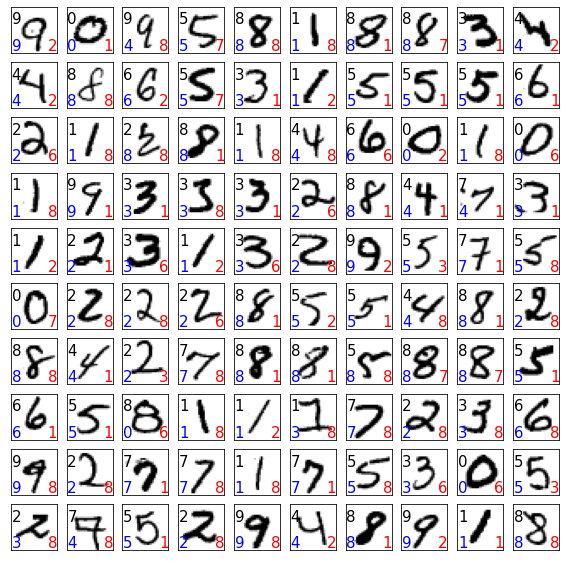

In [89]:
import matplotlib.pyplot as plt

# plot sample test images together with their groundtruth 
# and predicted labels before and after training

fig, axes = plt.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(wspace=0)
for a, image, true_label, pred_init, pred_trained in zip(
        axes.flatten(), test_data[selected],
        true_labels, preds_init, preds_trained):
    a.imshow(image.reshape(28, 28), cmap='gray_r')
    a.text(0, 10, str(true_label), color="black", size=15)
    a.text(0, 26, str(pred_trained), color="blue", size=15)
    a.text(22, 26, str(pred_init), color="red", size=15)

    a.set_xticks(())
    a.set_yticks(())

plt.show()